In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據
data_path = r'C:\Users\rex\Desktop\水位預測\3\1510H057.csv'   # 檔案位置(可更改位置)
data = pd.read_csv(data_path)
# 定義 時間索引 欄位
def create_timestamp(data):
    # 將"Date"和"Time"合併成時間戳記並設置為索引
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    data = data.set_index('Timestamp')
    return data

# 原始資料加入時間索引
data = create_timestamp(data)
print (data)
data.head(5)



                           Date   Time  1510H057 Water Level  19335 Rainfall
Timestamp                                                                   
2020-01-01 00:00:00    2020/1/1  00:00                 88.47        0.000000
2020-01-01 01:00:00    2020/1/1  01:00                 88.79        0.000000
2020-01-01 02:00:00    2020/1/1  02:00                 88.78        0.000000
2020-01-01 03:00:00    2020/1/1  03:00                 88.84        0.000000
2020-01-01 04:00:00    2020/1/1  04:00                 88.81        1.428012
...                         ...    ...                   ...             ...
2022-12-31 19:00:00  2022/12/31  19:00                 88.83        0.000000
2022-12-31 20:00:00  2022/12/31  20:00                 88.82        0.000000
2022-12-31 21:00:00  2022/12/31  21:00                 88.80        0.055771
2022-12-31 22:00:00  2022/12/31  22:00                 88.81        0.000000
2022-12-31 23:00:00  2022/12/31  23:00                 88.81        0.014507

,Date,Time,1510H057 Water Level,19335 Rainfall
Timestamp,,,,
2020-01-01 00:00:00,2020/1/1,00:00,88.47,0.000000
2020-01-01 01:00:00,2020/1/1,01:00,88.79,0.000000
2020-01-01 02:00:00,2020/1/1,02:00,88.78,0.000000
2020-01-01 03:00:00,2020/1/1,03:00,88.84,0.000000
2020-01-01 04:00:00,2020/1/1,04:00,88.81,1.428012


In [3]:
# 水位四捨五入小數第一位
data['1510H057 Water Level'] = data['1510H057 Water Level'].round(1)
# -------------------------------------------------------------------------------------------------------------------
# 列出所有要增加特徵的欄位名稱
columns_to_expand = ["1510H057 Water Level","19335 Rainfall"]

# 1.產出_T-1到_T-72的特徵
for col in columns_to_expand:
    for t in range(1, 73):
        new_col_name = f"{col}_T-{t}"
        data[new_col_name] = data[col].shift(t)
# -------------------------------------------------------------------------------------------------------------------       
# 2.產出每個月的平均水位
monthly_mean = data.groupby(data.index.month)[f"1510H057 Water Level"].mean()
#  創建一個新列，其中包含每個時間戳記與其對應月份的平均水位
data[f"1510H057 Water Level_monthly_mean"] = data.index.month.map(monthly_mean)
# -------------------------------------------------------------------------------------------------------------------
# 3. 創建水位距平值：當前水位(T-0)和(T-1~T-72)與月平均水位的差值
data[f"1510H057 Water Level_distance"] = data[f"1510H057 Water Level"] - data[f"1510H057 Water Level_monthly_mean"]

for t in range(1, 73):
    new_col_name = f"1510H057 Water Level_distance_T-{t}"
    data[new_col_name] = data["1510H057 Water Level_distance"].shift(t) 
# -------------------------------------------------------------------------------------------------------------------
# 4.計算3、6、9、12、24、48、72小時的累積雨量
time_intervals = [3, 6, 9, 12, 24, 48, 72]

for interval in time_intervals:
    col_name = f"19335 Rainfall_{interval}h_cumsum"
    data[col_name] = data["19335 Rainfall"].rolling(window=interval).sum()
# -------------------------------------------------------------------------------------------------------------------
# 5.增加T+1的雨量
for station in ["19335 Rainfall"]:
    col = f"{station}"
    for t in range(1,2):
        future_col_name = f"{col}_T+{t}"
        data[future_col_name] = data[col].shift(-t)
        
# 刪除包含NaN的行
data = data.dropna()
# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)  
print(data)

                     1510H057 Water Level  19335 Rainfall  \
Timestamp                                                   
2020-01-04 00:00:00                  88.1        0.000000   
2020-01-04 01:00:00                  88.2        0.000000   
2020-01-04 02:00:00                  88.2        0.000000   
2020-01-04 03:00:00                  88.2        0.000000   
2020-01-04 04:00:00                  88.2        0.000000   
...                                   ...             ...   
2022-12-31 18:00:00                  88.8        0.000000   
2022-12-31 19:00:00                  88.8        0.000000   
2022-12-31 20:00:00                  88.8        0.000000   
2022-12-31 21:00:00                  88.8        0.055771   
2022-12-31 22:00:00                  88.8        0.000000   

                     1510H057 Water Level_T-1  1510H057 Water Level_T-2  \
Timestamp                                                                 
2020-01-04 00:00:00                      88.2           

In [ ]:
# 特徵輸出

df = pd.DataFrame(data)

df.to_csv('資料.csv', index=True)  # 如果不想保留索引，可以將 index 參數設為 False

In [4]:
# 標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_features, columns=data.columns, index=data.index)

In [5]:
# 列出目標水位列
target_columns = ["1510H057 Water Level"]

# 增加目標列：T+1的目標水位
for target_col in target_columns:
    for t in range(1, 2):
        target = f'{target_col}_target_{t}'
        scaled_data[target] = data[target_col].shift(-t)

# 移除含有 NaN 的行
scaled_data = scaled_data.dropna()

In [ ]:
scaled_data

In [7]:
# 使用 RandomizedSearchCV 選取區間最佳化參數
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# 切分數據為訓練和測試集
X = scaled_data.drop([f'1510H057 Water Level_target_1'], axis=1)  # 特徵
y = scaled_data[f'1510H057 Water Level_target_1']  # 目標變數

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 切分訓練和測試集

# 定義參數的範圍
param_dist = {
    'objective': ['regression'],  # 回歸問題
    'num_leaves': randint(24, 35),  # 樹的最大葉子數
    'learning_rate': uniform(0.01, 0.03),  # 學習率
    'n_estimators': randint(650, 760),  # 樹的數量
    'max_bin': randint(30, 50),  # 最大bin數量
    'subsample': uniform(0.7, 0.85),  # 子樣本比例
    'subsample_freq': randint(2, 5),  # 子樣本選擇頻率
    'colsample_bytree': uniform(0.7, 0.85),  # 每棵樹使用特徵的比例
    'min_child_samples': randint(4, 7),  # 每個葉子節點上的最小樣本數
    'min_child_weight': randint(10, 13),  # 最小子節點權重和
    'device': ['gpu'],  # 使用GPU進行計算
}

lgb_estimator = lgb.LGBMRegressor(silent=True, verbose=0)  # 定義LightGBM模型

# 隨機搜索參數
rsearch = RandomizedSearchCV(estimator=lgb_estimator,
                             param_distributions=param_dist,
                             n_iter=1000,  # 嘗試的參數組合次數
                             cv=5,  # 交叉驗證的折數
                             verbose=1,
                             n_jobs=5,  # 使用的CPU核心數
                             random_state=42)

rsearch.fit(X_train, y_train)  # 在訓練數據上進行隨機搜索

# 輸出最佳參數和分數
print('Best parameters found by random search are', rsearch.best_params_)
print('Best score found by random search is', rsearch.best_score_)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

In [8]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.layers import TimeDistributed, Flatten
from lightgbm import early_stopping
from joblib import dump
import json

In [9]:
# MAPE計算函數
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


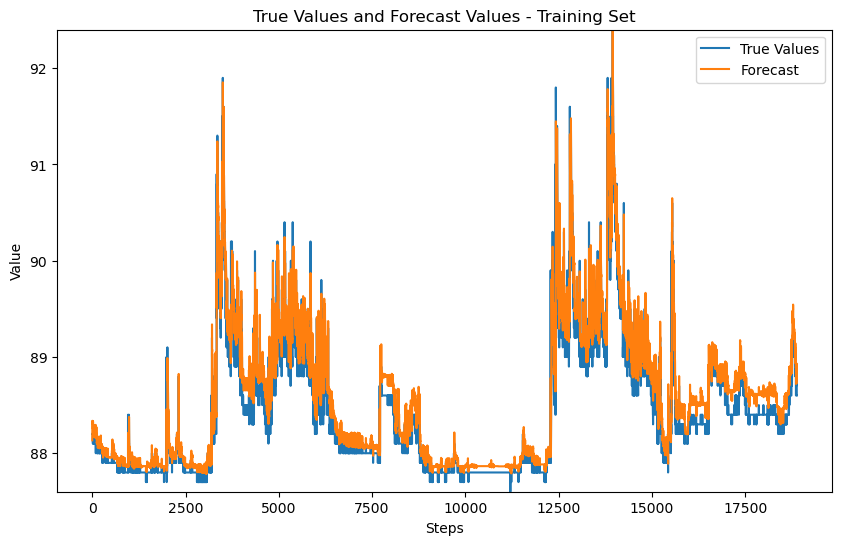

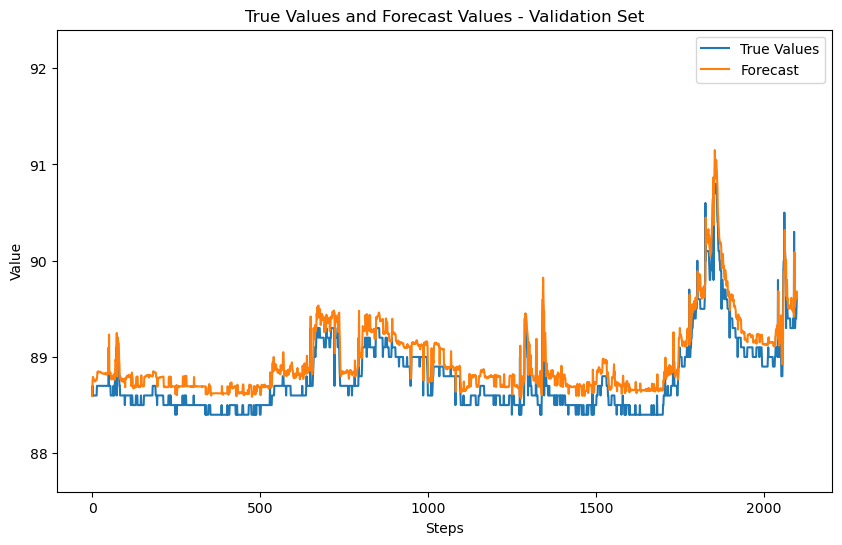

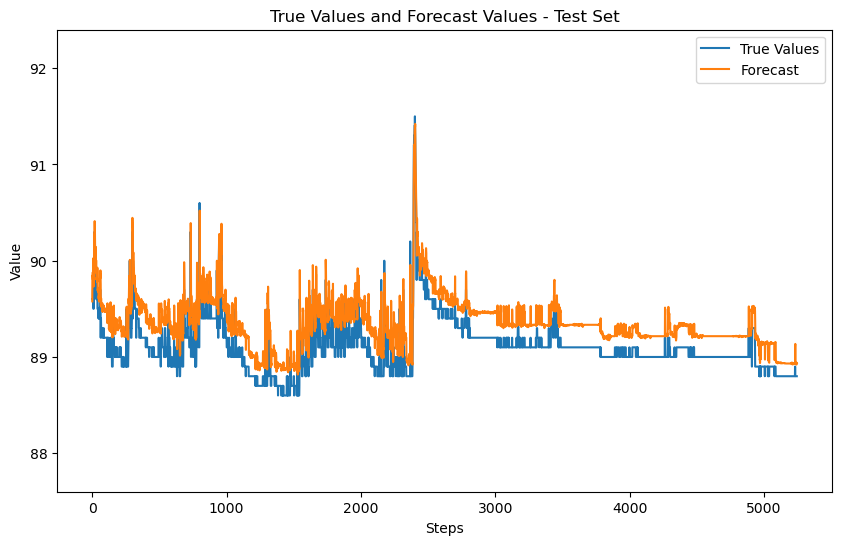

Important features:
1. 1510H057 Water Level - 1381
2. 1510H057 Water Level_T-1 - 246
3. 19335 Rainfall_T+1 - 428
4. 1510H057 Water Level_distance - 186
5. 1510H057 Water Level_distance_T-23 - 90
6. 19335 Rainfall - 115
7. 19335 Rainfall_T-6 - 95
8. 19335 Rainfall_T-1 - 67
9. 1510H057 Water Level_T-23 - 88
10. 1510H057 Water Level_T-47 - 68
11. 1510H057 Water Level_T-2 - 43
12. 19335 Rainfall_T-7 - 45
13. 1510H057 Water Level_distance_T-47 - 42
14. 19335 Rainfall_T-55 - 51
15. 1510H057 Water Level_T-72 - 54
16. 19335 Rainfall_T-54 - 42
17. 1510H057 Water Level_T-71 - 27
18. 1510H057 Water Level_distance_T-24 - 49
19. 19335 Rainfall_6h_cumsum - 37
20. 19335 Rainfall_T-3 - 65
21. 1510H057 Water Level_distance_T-1 - 63
22. 1510H057 Water Level_T-24 - 49
23. 19335 Rainfall_T-5 - 65
24. 19335 Rainfall_72h_cumsum - 57
25. 19335 Rainfall_3h_cumsum - 202
26. 19335 Rainfall_T-56 - 141
27. 1510H057 Water Level_distance_T-71 - 32
28. 19335 Rainfall_24h_cumsum - 28
29. 19335 Rainfall_T-2 - 55
30. 1

In [18]:
# 設定隨機種子
seed_value = 42

# 分割數據集為訓練和測試集
train_size = int(len(scaled_data) * 0.8)
val_size = int(train_size * 0.1)
train_data = scaled_data[:train_size-val_size]
val_data = scaled_data[train_size-val_size:train_size]
test_data = scaled_data[train_size:]

X_train = train_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_train = train_data["1510H057 Water Level_target_1"]

X_val = val_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_val = val_data["1510H057 Water Level_target_1"]

X_test = test_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_test = test_data["1510H057 Water Level_target_1"]

# 訓練 LightGBM 模型
model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=24,
    learning_rate=0.026280882494747457,
    n_estimators=694,
    max_bin=38,
    subsample=0.7132909457300148,
    subsample_freq=2,
    colsample_bytree=0.9387943332342736,
    min_child_samples=4,
    min_child_weight=12,
    verbose=0,
    device='gpu',
    random_state=seed_value
)
model.fit(X_train, y_train)

# 儲存模型和特徵名稱
if not os.path.exists("model"):
    os.makedirs("model")
dump(model, 'model/lgb_model.joblib')

# Save the feature names as a JSON file
with open('model/feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f)

WINDOW_SIZE = 72

# 定義多步預測函數
def recursive_forecast(model, X_test, y_test, steps=288):
    forecast = []
    true_values = []
    r2_scores = []
    mape_scores = []

    X_test_copy = X_test.copy()
    
    for i in range(steps):
        features = X_test_copy.iloc[i].values.reshape(1, -1)
        true_value = y_test.iloc[i]
        true_values.append(true_value)
        
        pred = model.predict(features)
        forecast.append(pred[0])

        if i < steps - 1:
            X_test_copy.iloc[i + 1, -WINDOW_SIZE:] = np.hstack((X_test_copy.iloc[i, -WINDOW_SIZE:-1].values, [pred[0]]))    
            
        r2_scores.append(r2_score(true_values, forecast))
        mape_scores.append(mean_absolute_percentage_error(true_values, forecast))

    return forecast, true_values, r2_scores, mape_scores


# 找到全局最大值和最小值
global_min = min(y_train.min(), y_val.min(), y_test.min())
global_max = max(y_train.max(), y_val.max(), y_test.max())

# 進行多步預測並評估結果
sets = [
    ("Training Set", X_train, y_train),
    ("Validation Set", X_val, y_val),
    ("Test Set", X_test, y_test)
]

for set_name, X, y in sets:
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X.reset_index(drop=True), y.reset_index(drop=True), steps=len(X))

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title(f'True Values and Forecast Values - {set_name}')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    plt.show()
    
# 取得重要特徵名稱與重要評分
feature_importances = model.feature_importances_
important_features = X_train.columns[feature_importances.argsort()[::-1]]

print("Important features:")
for i, feature_name in enumerate(important_features):
    print(f"{i+1}. {feature_name} - {feature_importances[important_features.get_loc(feature_name)]}")
    
print("-------------------------------------------------------------------------")
# 保存R²和MAPE得分到一個Excel文件
results_df = pd.DataFrame({
    'Step': list(range(1, len(X) + 1)),
    'R² Score': r2_scores,
    'MAPE Score': mape_scores
})

results_df.to_excel(f'{set_name.lower().replace(" ", "_")}_multi_step_forecast_results.xlsx', index=False)

print(f"R² and MAPE scores for {set_name} have been saved to '{set_name.lower().replace(' ', '_')}_multi_step_forecast_results.xlsx'")

In [ ]:
# 將分割後的資料儲存到Excel文件中
with pd.ExcelWriter('data_splits.xlsx') as writer:
    train_data.to_excel(writer, sheet_name='Train Data', index=False)
    val_data.to_excel(writer, sheet_name='Validation Data', index=False)
    test_data.to_excel(writer, sheet_name='Test Data', index=False)

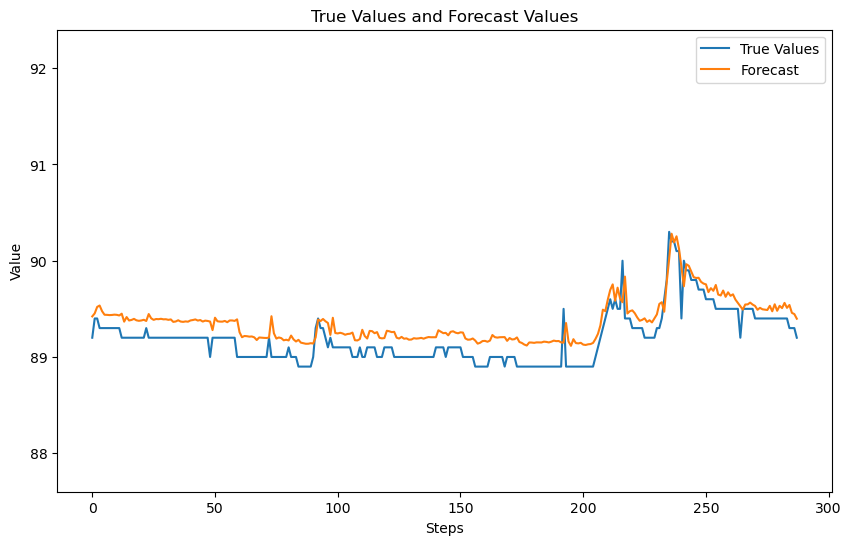

([89.42133500474438,
  89.45285487960774,
  89.51992879016375,
  89.5344744739779,
  89.47583472344296,
  89.4386380627545,
  89.43759875856273,
  89.43504491105217,
  89.4363655239207,
  89.4396901381054,
  89.43777717996971,
  89.43110354038424,
  89.44957831154738,
  89.367036984941,
  89.41462950550624,
  89.37903045175257,
  89.38470901549778,
  89.39577795287568,
  89.38083440107114,
  89.37559586809063,
  89.37928927556543,
  89.38625209930932,
  89.37403187292655,
  89.445991293327,
  89.40168960754667,
  89.38555642241249,
  89.39427345990656,
  89.39267260029415,
  89.39654367144279,
  89.39097860131356,
  89.39204064576371,
  89.38585590167182,
  89.3900626254224,
  89.36471667653265,
  89.36871698267367,
  89.38134383686871,
  89.36803424300136,
  89.3647177038336,
  89.36929338306548,
  89.36662861256573,
  89.37953408645006,
  89.38395083771435,
  89.39006836548859,
  89.37828905540397,
  89.38368926878863,
  89.3678959754321,
  89.37745895977135,
  89.37419291150285,
  8

In [26]:
from joblib import dump

def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    # 獲取對應的X_test和y_test
    X_test = scaled_data.iloc[idx_start:idx_end].drop(["1510H057 Water Level_target_1"], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end]["1510H057 Water Level_target_1"].reset_index(drop=True)

    # 進行多步預測
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test, steps=steps)

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    plt.show()

    return forecast, true_values, r2_scores, mape_scores

# 使用新建的函數進行預測，您可以更改 '2023-01-01 00:00:00' 為您想要的時間點
forecast_from_timestamp('2022-05-29 23:00:00')